LEO (2000 km) → Orbital period = 2.12 hr
MEO (15000 km) → Orbital period = 8.64 hr
GEO (35786 km) → Orbital period = 23.93 hr


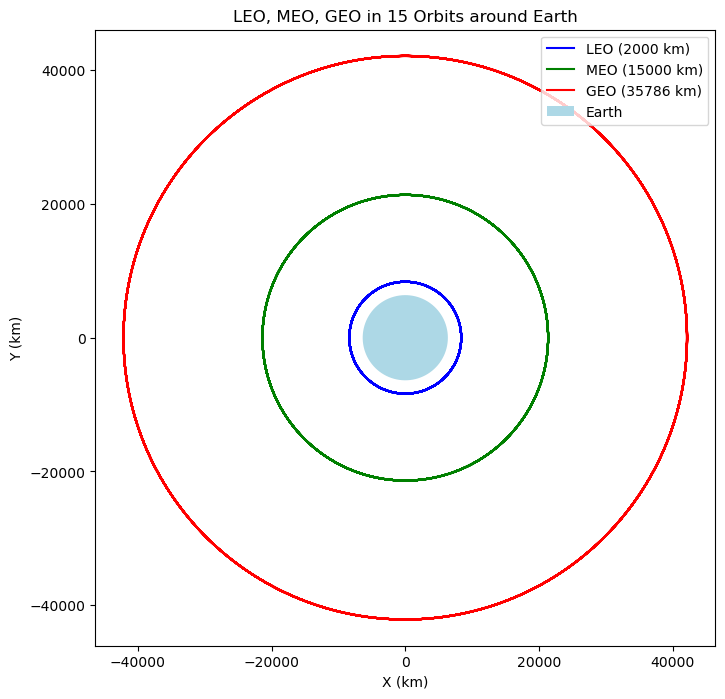

In [205]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

mu = 398600  # km^3/s^2

def two_body(t, state):
    r = state[0:3]
    v = state[3:6]
    r_norm = np.linalg.norm(r)
    a = -mu * r / r_norm**3
    return np.hstack((v, a))

earth_radius = 6371  # km
alts = [2000, 15000, 35786]  # (LEO, MEO, GEO)
colors = ['blue', 'green', 'red']
labels = ['LEO (2000 km)', 'MEO (15000 km)', 'GEO (35786 km)']

plt.figure(figsize=(8,8))

for alt, color, label in zip(alts, colors, labels):
    r0 = np.array([earth_radius + alt, 0, 0])
    r_mag = np.linalg.norm(r0)
    v0 = np.array([0, np.sqrt(mu/r_mag), 0])
    state0 = np.hstack((r0, v0))

    # Orbital period
    T = 2*np.pi*np.sqrt(r_mag**3/mu)
    print(f"{label} → Orbital period = {T/3600:.2f} hr")

    t_span = (0, 15*T)  # simulate 5 orbits
    t_eval = np.linspace(*t_span, 2000)

    sol = solve_ivp(two_body, t_span, state0, t_eval=t_eval, rtol=1e-6, atol=1e-6)

    # Plot orbit
    plt.plot(sol.y[0], sol.y[1], color=color, label=label)

theta = np.linspace(0, 2*np.pi, 100)
x_earth = earth_radius * np.cos(theta)
y_earth = earth_radius * np.sin(theta)
plt.fill(x_earth, y_earth, 'lightblue', label='Earth')

plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.axis("equal")
plt.title("LEO, MEO, GEO in 15 Orbits around Earth")
plt.legend()
plt.show()

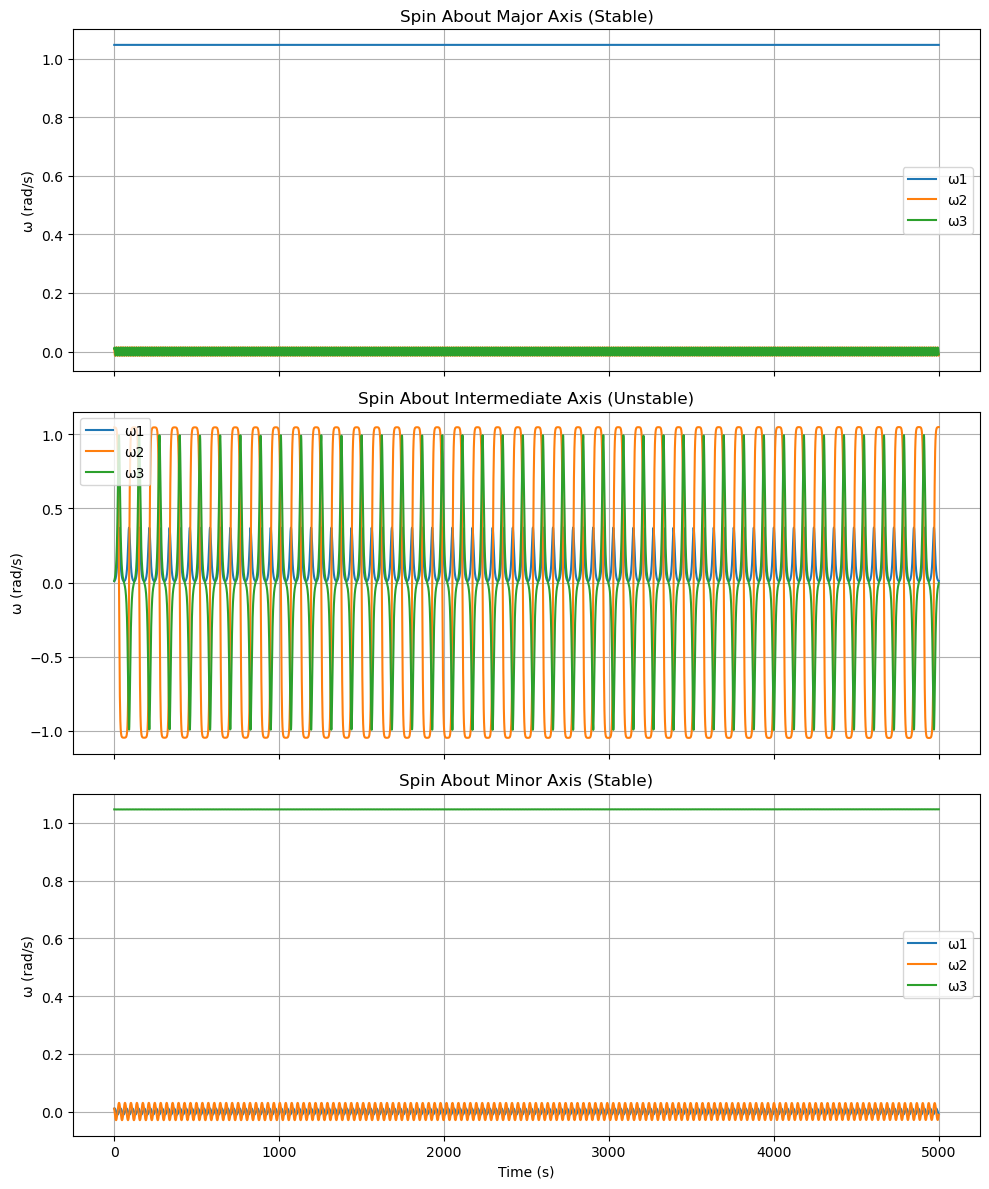

In [235]:
I11 = 153.68  # major
I22 = 110.7  # intermediate
I33 = 101.67   # minor

def euler_eq(t, omega):
    w1, w2, w3 = omega
    dw1 = ((I22 - I33)/I11) * w2 * w3
    dw2 = ((I33 - I11)/I22) * w3 * w1
    dw3 = ((I11 - I22)/I33) * w1 * w2
    return [dw1, dw2, dw3]

# 10 RPM in rad/s
omega_mag = 10 * 2*np.pi / 60  

t_span = (0, 5000)
t_eval = np.linspace(*t_span, 5000)

# small perturbations
eps = 1e-2

# Major axis 
omega0_major = [omega_mag, eps, eps]
sol_major = solve_ivp(euler_eq, t_span, omega0_major, t_eval=t_eval, rtol = 1e-5, atol=1e-5)

# Intermediate axis
omega0_inter = [eps, omega_mag, eps]
sol_inter = solve_ivp(euler_eq, t_span, omega0_inter, t_eval=t_eval, rtol = 1e-5, atol=1e-5)

# Minor axis 
omega0_minor = [eps, eps, omega_mag]
sol_minor = solve_ivp(euler_eq, t_span, omega0_minor, t_eval=t_eval, rtol = 1e-5, atol=1e-5)

fig, axes = plt.subplots(3,1, figsize=(10,12), sharex=True)

# Major axis
axes[0].plot(sol_major.t, sol_major.y[0], label='ω1')
axes[0].plot(sol_major.t, sol_major.y[1], label='ω2')
axes[0].plot(sol_major.t, sol_major.y[2], label='ω3')
axes[0].set_ylabel("ω (rad/s)")
axes[0].set_title("Spin About Major Axis (Stable)")
axes[0].legend()
axes[0].grid(True)

# Intermediate axis
axes[1].plot(sol_inter.t, sol_inter.y[0], label='ω1')
axes[1].plot(sol_inter.t, sol_inter.y[1], label='ω2')
axes[1].plot(sol_inter.t, sol_inter.y[2], label='ω3')
axes[1].set_ylabel("ω (rad/s)")
axes[1].set_title("Spin About Intermediate Axis (Unstable)")
axes[1].legend()
axes[1].grid(True)

# Minor axis
axes[2].plot(sol_minor.t, sol_minor.y[0], label='ω1')
axes[2].plot(sol_minor.t, sol_minor.y[1], label='ω2')
axes[2].plot(sol_minor.t, sol_minor.y[2], label='ω3')
axes[2].set_xlabel("Time (s)")
axes[2].set_ylabel("ω (rad/s)")
axes[2].set_title("Spin About Minor Axis (Stable)")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

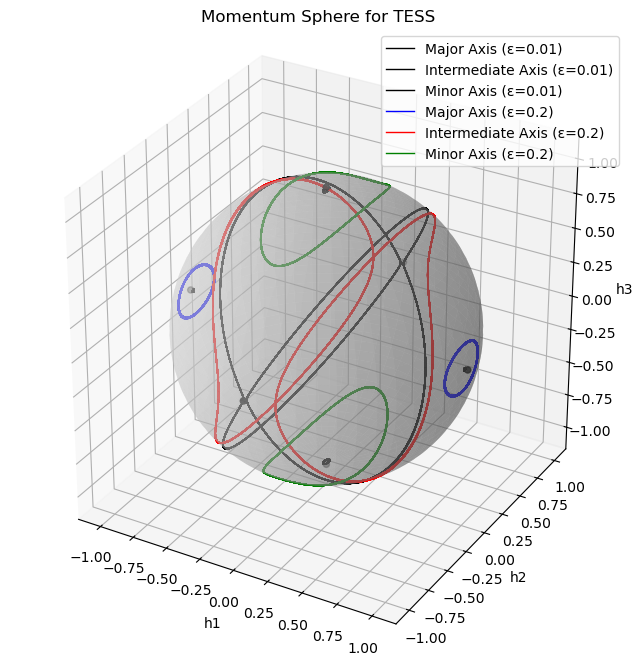

In [262]:
eps_values = [0.01, 0.2]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

u = np.linspace(-np.pi, np.pi, 100)
v = np.linspace(0, np.pi, 100)

x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones_like(u), np.cos(v))

ax.plot_surface(x, y, z, color='lightgray', alpha=0.4)

axes_pts = 1.02
ax.scatter([ axes_pts, -axes_pts, 0, 0, 0, 0],
           [0, 0,  axes_pts, -axes_pts, 0, 0],
           [0, 0, 0, 0,  axes_pts, -axes_pts],
           color='k')

# ---- Loop over epsilon values ----
for eps in eps_values:

    # Choose colors
    if eps == 0.01:
        major_color = inter_color = minor_color = 'black'
        label_suffix = " (ε=0.01)"
    else:
        major_color = 'blue'
        inter_color = 'red'
        minor_color = 'green'
        label_suffix = " (ε=0.2)"

    # Major axis
    omega0 = [omega_mag, eps, eps]
    sol = solve_ivp(euler_eq, t_span, omega0, t_eval=t_eval, rtol=1e-5, atol=1e-5)
    h = compute_normalized_h(sol)
    ax.plot(h[0], h[1], h[2],linewidth=1,color=major_color,label="Major Axis" + label_suffix)
    ax.plot(-h[0], -h[1], -h[2], linewidth=1,color=major_color)
    
    # Intermediate axis
    omega0 = [eps, omega_mag, eps]
    sol = solve_ivp(euler_eq, t_span, omega0, t_eval=t_eval, rtol=1e-5, atol=1e-5)
    h = compute_normalized_h(sol)
    ax.plot(h[0], h[1], h[2], linewidth=1, color=inter_color, label="Intermediate Axis" + label_suffix)
    ax.plot(-h[0], -h[1], -h[2], linewidth=1,color=inter_color)
    
    # Minor axis
    omega0 = [eps, eps, omega_mag]
    sol = solve_ivp(euler_eq, t_span, omega0, t_eval=t_eval, rtol=1e-5, atol=1e-5)
    h = compute_normalized_h(sol)
    ax.plot(h[0], h[1], h[2], linewidth=1,color=minor_color,label="Minor Axis" + label_suffix)
    ax.plot(-h[0], -h[1], -h[2], linewidth=1,color=minor_color)
    
ax.set_xlabel('h1')
ax.set_ylabel('h2')
ax.set_zlabel('h3')
ax.set_title('Momentum Sphere for TESS')
ax.set_box_aspect([1,1,1])

ax.legend()
plt.show()